In [1]:
import sys
sys.path.append('../utils')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from MiguelTK import *
import warnings
warnings.filterwarnings('ignore')

## Limpieza y transformación de datos

In [2]:
df = pd.read_csv('data/ZARA_db.csv')

In [3]:
df.head()

,extracción,articulo,precio,descripcion,grupo_web,tallas,colores,enlace,marca,grupo,seccion
0,2024-05-26 22:07:01.568835,CHAQUETA PUNTO BOTÓN FLOR,27.95,Chaqueta de escote pico y manga por debajo del...,V2024-MUJER-ULTIMA-SEMANA,"['XS', 'S', 'M', 'L']",[],https://www.zara.com/es/es/chaqueta-punto-boto...,ZARA,CHAQUETA,MUJER
1,2024-05-26 22:07:01.568835,PANTALÓN VUELTA BAJO ZW COLLECTION,39.95,ZARA WOMAN COLLECTIONPantalón de tiro medio y ...,V2024-MUJER-ULTIMA-SEMANA,"['XS', 'S', 'M', 'L', 'XL']",[],https://www.zara.com/es/es/pantalon-vuelta-baj...,ZARA,PANTALÓN,MUJER
2,2024-05-26 22:07:01.568835,BODY TUL ESTAMPADO ANIMAL,15.95,Cebra | 5039/509,V2024-MUJER-ULTIMA-SEMANA,"['S', 'M', 'L']",[],https://www.zara.com/es/es/body-tul-estampado-...,ZARA,BODY,MUJER
3,2024-05-26 22:07:01.568835,VESTIDO MINI LENCERO,35.95,Vestido de escote pico y tirantes. Forro inter...,V2024-MUJER-ULTIMA-SEMANA,"['XS', 'S', 'M', 'L', 'XL']",[],https://www.zara.com/es/es/vestido-mini-lencer...,ZARA,VESTIDO,MUJER
4,2024-05-26 22:07:01.568835,PANTALÓN RECTO JACQUARD,39.95,Pantalón de tiro alto con cintura elástica en ...,V2024-MUJER-ULTIMA-SEMANA,"['XS', 'S', 'M', 'L', 'XL']",[],https://www.zara.com/es/es/pantalon-recto-jacq...,ZARA,PANTALÓN,MUJER


In [4]:
df['temporada'] = df['grupo_web'].str.extract(r'^(\w+)\-')
del df['grupo_web']

In [5]:
df['n_tallas'] = df['tallas'].str.count(r'\'(\w+)\'')

In [6]:
del df['enlace']

In [7]:
df['n_colores'] = df['colores'].str.count(r'\'(\w+)\'')

In [8]:
df['contiene_lino'] = df['descripcion'].str.contains(r'lino',case=False)

In [9]:
df['contiene_algodon'] = df['descripcion'].str.contains(r'algodón',case=False)

In [10]:
df['tipo_talla'] = (
    df['tallas']
    .str.contains(r'\d')
    .map({
        True:'numérica',
        False:'alfabética'
    })
)

In [11]:
df['colores'] = df['colores'].str.upper()

## Estudio de colores

In [12]:
tabla_colores = (
    df['colores']
    .str.replace(r'[\[\]\']','',regex=True)
    .str.replace(r'\,\s',',',regex=True)
    .str.split(',',expand=True)
    .assign(seccion = df['seccion'])
    .melt('seccion')
    .drop(columns='variable')
    .dropna(subset='value')
    .query('value != ""')
)
tabla_colores

,seccion,value
7,MUJER,BEIGE CLARO
12,MUJER,NEGRO
15,MUJER,PLATA
21,MUJER,BLANCO
26,MUJER,BLANCO
...,...,...
5658,MUJER,CRUDO / AZUL
6289,MUJER,CAVA
6920,MUJER,KHAKI
7551,MUJER,MULTICOLOR


In [13]:
B_N = (
    tabla_colores
    ['value']
    .str.contains(r'(NEGRO)|(BLANCO)',regex=True)
)

Colores más frecuentes por sección (diferentes al blanco y negro)


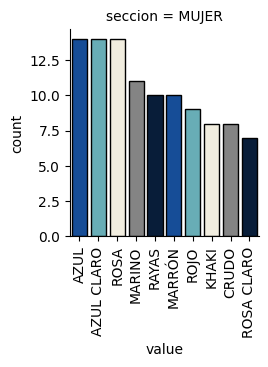

In [14]:
df_ = (
    tabla_colores[~B_N]
    .groupby('seccion',as_index=False)
    ['value']
    .value_counts()
    .groupby('seccion')
    .apply(lambda x: x.nlargest(10,'count'))
)
grid = sns.FacetGrid(df_,col='seccion',sharex=False)
grid.map(sns.barplot,'value','count',**kwargs)
grid.tick_params('x',rotation=90)
print('Colores más frecuentes por sección (diferentes al blanco y negro)')

In [15]:
df_ = (
    tabla_colores[~B_N]
    .groupby('seccion',as_index=False)
    ['value']
    .value_counts()
    .groupby('seccion')
    .apply(lambda x: x.nsmallest(10,'count'))
    .drop(columns='seccion')
    .reset_index()
    .drop(columns=['level_1','count'])
)
print('Colores menos frecuentes por sección (diferentes al blanco y negro)')
print(df_)

Colores menos frecuentes por sección (diferentes al blanco y negro)
  seccion             value
0   MUJER      ARENA/MARRÓN
1   MUJER               TAN
2   MUJER            TABACO
3   MUJER       SOLAR GLAZE
4   MUJER           APRICOT
5   MUJER         ROSA TIZA
6   MUJER      FUCSIA CLARO
7   MUJER  ANTRACITA OSCURO
8   MUJER        ROSA MEDIO
9   MUJER     AZUL / MARINO


<Axes: xlabel='seccion', ylabel='n_colores'>

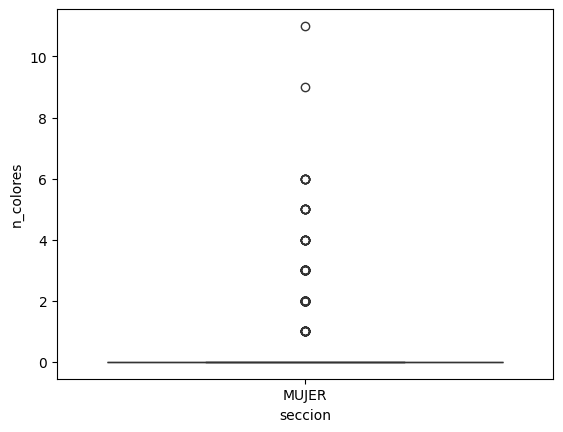

In [16]:
sns.boxplot(
    data = df,
    x = 'seccion',
    y = 'n_colores',
    palette = palette
)

La ropa masculina tiene mayor variedad en los colores disponibles.

## Estudio de composición

In [17]:
df['contiene_lino'].value_counts(normalize=True)

contiene_lino
False    0.889065
True     0.110935
Name: proportion, dtype: float64

El `11 %` de las prendas de ropa contienen lino

In [18]:
df['contiene_algodon'].value_counts(normalize=True)

contiene_algodon
False    0.914422
True     0.085578
Name: proportion, dtype: float64

El `15 %` de las prendas de ropa contienen algodón

In [19]:
pd.crosstab(
    df['contiene_lino'],
    df['seccion'],
    normalize='index'
)

seccion,MUJER
contiene_lino,
False,1.0
True,1.0


In [20]:
pd.crosstab(
    df['contiene_algodon'],
    df['seccion'],
    normalize='index'
)

seccion,MUJER
contiene_algodon,
False,1.0
True,1.0


Las prendas de ropa que contienen o bien lino o bien algodón tienen más posibilidades de ser de la sección masculina.

<Axes: xlabel='contiene_lino', ylabel='precio'>

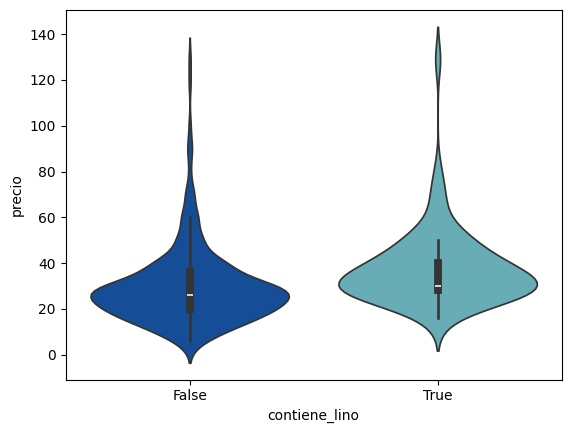

In [21]:
sns.violinplot(
    data = df,
    x = 'contiene_lino',
    y = 'precio',
    palette = palette
)

Las prendas que contienen `lino` pueden tener precios más altos que las que no lo contienen.

## Estudio de tallas

### Tallas extremas

#### Tallas letras

In [22]:
df_ = df.query('tipo_talla == "alfabética"')

In [23]:
pd.crosstab(
    df_['tallas'].str.contains('XS'),
    df_['seccion'],
    normalize = 'index'
)

seccion,MUJER
tallas,
False,1.0
True,1.0


In [24]:
pd.crosstab(
    df_['tallas'].str.contains('XL'),
    df_['seccion'],
    normalize = 'index'
)

seccion,MUJER
tallas,
False,1.0
True,1.0


In [25]:
pd.crosstab(
    df_['tallas'].str.contains('XXL'),
    df_['seccion'],
    normalize = 'index'
)

seccion,MUJER
tallas,
False,1.0
True,1.0


- Las prendas que tienen la talla `XS` disponible pertenecen casi todas a la sección femenina. 
- Las prendas con las talla `XL` disponible están en mayor equilibrio.
- Las prendas que tienen disponible la talla `XXL` pertenecen en mayor proporción a la sección femenina, y las que no tienen esa talla disponible son en su mayoría de caballero.

### Número de tallas disponibles

<Axes: xlabel='seccion', ylabel='n_tallas'>

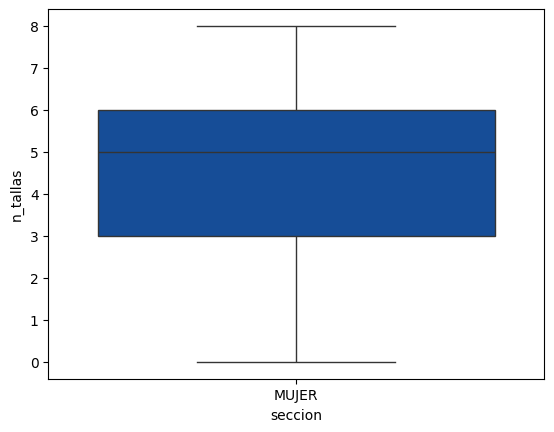

In [26]:
sns.boxplot(
    data = df,
    x = 'seccion',
    y = 'n_tallas',
    palette = palette
)

La ropa de la sección de mujer ofrece una mayor variedad de tallas.

## Palabras clave
porcentaje de prendas cuya descripción contiene la palabra clave:

In [34]:
# RELAXED
df['descripcion'].str.contains('relaxed',case=False).sum() / len(df)

0.003169572107765452

In [35]:
# FIT
df['descripcion'].str.contains('fit',case=False).sum() / len(df)

0.060221870047543584

In [29]:
# BRILLOS
df['descripcion'].str.contains(r'brillos?',case=False).sum() / len(df)

0.022187004754358162

In [30]:
# ESTAMPADO ANIMAL
df['descripcion'].str.contains(r'estampado\sanimal',case=False,regex=True).sum() / len(df)

0.001584786053882726

In [31]:
# ASIMÉTRICO
df['descripcion'].str.contains(r'asimétric[oa]',case=False).sum() / len(df)

0.0554675118858954

In [32]:
# OVERSIZE
df['descripcion'].str.contains(r'over\s?size',case=False).sum() / len(df)

0.009508716323296355

In [33]:
# EFECTO ARRUGADO
df['descripcion'].str.contains(r'efecto arrugado',case=False).sum() / len(df)

0.00792393026941363